In [153]:
# Import libraries
from io import StringIO
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# load data directories
lun_cat_directory = './space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
lun_cat_file = lun_cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(lun_cat_file)

row = cat.iloc[65]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
lunar_training_file = row.filename

lunar_test_data_directory = './space_apps_2024_seismic_detection/data/lunar/test/data'
lunar_training_data_directory = './space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'

mars_test_data_directory = './space_apps_2024_seismic_detection/data/mars/test/data'
mars_training_data_directory = './space_apps_2024_seismic_detection/data/mars/training/data'



In [154]:
#Reading a specific training file .csv

data_directory = './space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{lunar_training_file}.csv'
data_cat = pd.read_csv(csv_file)
csv_file

# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']

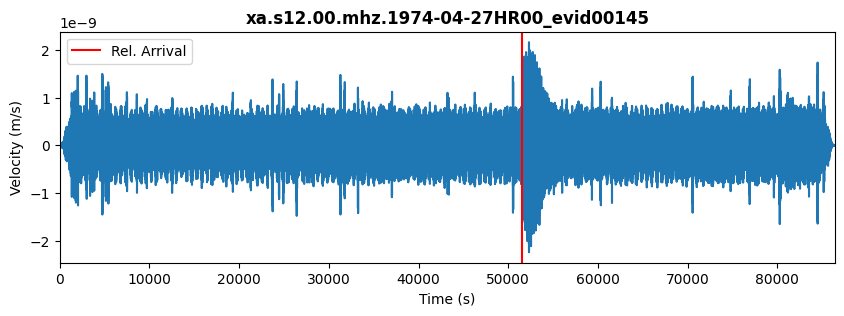

In [162]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)


# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{lunar_training_file}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

In [163]:
# Read the CSV file
data_cat = pd.read_csv(csv_file)

# Feature Engineering: Compute STA/LTA using the smoothed velocity signal
def compute_sta_lta(data, sta_window, lta_window):
    sta = data.rolling(window=sta_window).mean()
    lta = data.rolling(window=lta_window).mean()
    sta_lta_ratio = sta / (lta + 1e-9)  # Avoid division by zero
    return sta_lta_ratio

# Compute STA/LTA using the smoothed velocity column
data_cat['STA_LTA'] = compute_sta_lta(data_cat['velocity(m/s)'], sta_window=5, lta_window=500)

# Prepare features using the smoothed data
features = data_cat[['velocity(m/s)', 'STA_LTA']].dropna()

# Scale the features before fitting the Isolation Forest
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train Isolation Forest Model with tuned parameters
iso_forest = IsolationForest(contamination=0.005, n_estimators=200, random_state=42)
iso_forest.fit(features_scaled)

# Predict anomalies on the scaled data
anomaly_scores = iso_forest.decision_function(features_scaled)
anomalies = iso_forest.predict(features_scaled)  # -1 indicates an anomaly

# Add results back to the original dataframe (ensure alignment after dropna)
data_cat = data_cat.dropna(subset=['STA_LTA'])  # Align the original df with feature df
data_cat['anomaly_scores'] = anomaly_scores
data_cat['anomaly'] = anomalies

# Show the detected anomalies
print(data_cat[data_cat['anomaly'] == -1])
print(data_cat[data_cat['anomaly'] == -1].shape)

# Save the results to a file
data_cat.to_csv('lunar_anomaly_results_scaled.csv', index=False)


       time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)   STA_LTA  \
8860       1974-04-27T00:22:18.004491    1337.358491   8.798290e-10  0.728044   
8888       1974-04-27T00:22:22.230906    1341.584906  -1.077263e-09 -0.513650   
8889       1974-04-27T00:22:22.381849    1341.735849  -1.073747e-09 -0.745934   
8890       1974-04-27T00:22:22.532792    1341.886792  -1.070231e-09 -0.957742   
8891       1974-04-27T00:22:22.683736    1342.037736  -1.066715e-09 -1.077300   
...                               ...            ...            ...       ...   
564189     1974-04-27T23:39:21.249774   85160.603774   9.719019e-10  0.810872   
564190     1974-04-27T23:39:21.400717   85160.754717   8.261969e-10  0.859310   
564199     1974-04-27T23:39:22.759208   85162.113208  -8.409998e-10 -0.641376   
564200     1974-04-27T23:39:22.910151   85162.264151  -9.100335e-10 -0.661424   
564201     1974-04-27T23:39:23.061094   85162.415094  -9.790672e-10 -0.795909   

        anomaly_scores  ano

/Users/Asher/Documents/GitHub/NASA/venvx/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/Users/Asher/Documents/GitHub/NASA/venvx/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


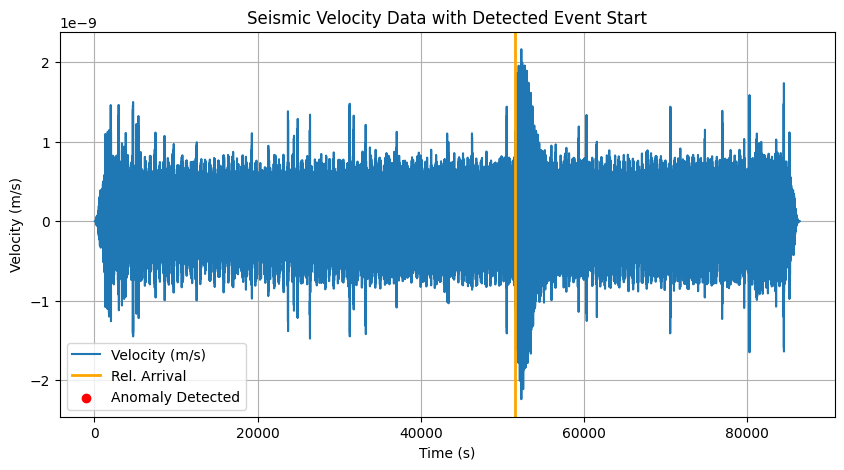

In [165]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.01, n_estimators=200, random_state=42)
iso_forest.fit(features_scaled)

# Predict anomalies
anomaly_scores = iso_forest.decision_function(features)
anomalies = iso_forest.predict(features)  # -1 indicates an anomaly

# Add the predictions back to the dataframe
data_cat['anomaly_scores'] = anomaly_scores
data_cat['anomaly'] = anomalies

# Find the first anomaly to plot the vertical line
first_anomaly_time = data_cat[data_cat['anomaly'] == -1]['time_rel(sec)'].min()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(data_cat['time_rel(sec)'], data_cat['velocity(m/s)'], label="Velocity (m/s)")

# Vertical line at actual anomaly
plt.axvline(x=arrival_time_rel, c='orange', label='Rel. Arrival', linewidth=2)

# Add a vertical line at the first detected anomaly
if not pd.isna(first_anomaly_time):
    plt.axvline(x=first_anomaly_time, color='green', linestyle='-', label='Detected Event Start', linewidth=2)

# Plot the anomaly points
anomalies = data_cat[data_cat['anomaly'] == -1]
plt.scatter(anomalies['time_rel(sec)'], anomalies['velocity(m/s)'], color='red', label='Anomaly Detected')

# Labels and title
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Seismic Velocity Data with Detected Event Start')
plt.legend()
plt.grid(True)
plt.show()


In [158]:
# Assuming 'data_cat' contains the original dataset

# First pass of Isolation Forest

features = data_cat[['velocity(m/s)', 'STA_LTA']].dropna()  # Original features
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(features)
anomalies = iso_forest.predict(features)  # -1 indicates an anomaly

# Extract anomalies from the first pass
data_anomalies = data_cat[anomalies == -1]

# Recalculate STA/LTA on the anomalies detected by the first Isolation Forest
def compute_sta_lta(data, sta_window, lta_window):
    sta = data.rolling(window=sta_window).mean()
    lta = data.rolling(window=lta_window).mean()
    sta_lta_ratio = sta / (lta + 1e-9)  # Avoid division by zero
    return sta_lta_ratio

# Compute STA/LTA for anomalies
data_anomalies['STA_LTA_2nd_pass'] = compute_sta_lta(data_anomalies['velocity(m/s)'], sta_window=5, lta_window=500)

# Second pass of Isolation Forest using recalculated STA/LTA on anomalies
features_anomalies = data_anomalies[['velocity(m/s)', 'STA_LTA_2nd_pass']].dropna()  # Refined features
iso_forest_2 = IsolationForest(contamination=0.01, random_state=42)
iso_forest_2.fit(features_anomalies)

# Predict anomalies again on refined features
anomaly_scores_2 = iso_forest_2.decision_function(features_anomalies)
anomalies_2 = iso_forest_2.predict(features_anomalies)  # -1 indicates an anomaly

# Add second pass anomaly results to the anomalies dataframe
data_anomalies['anomaly_scores_2nd_pass'] = anomaly_scores_2
data_anomalies['anomaly_2nd_pass'] = anomalies_2

# Save the results for analysis
data_anomalies.to_csv('lunar_anomaly_results_second_pass.csv', index=False)

# Show final detected anomalies
print(data_anomalies[data_anomalies['anomaly_2nd_pass'] == -1])


/var/folders/4k/dfyc8mw14qg4bl5d7q5yvtlm0000gn/T/ipykernel_21459/3597870054.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_anomalies['STA_LTA_2nd_pass'] = compute_sta_lta(data_anomalies['velocity(m/s)'], sta_window=5, lta_window=500)


ValueError: Length of values (5219) does not match length of index (5718)